In [58]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.nn import Conv1d
import torchaudio
import utils    
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()


import torch.optim as optim
import torch.nn.functional as F
import functools
import matplotlib.pyplot as plt
CUDA = torch.cuda.is_available()


In [9]:
# Define device for torch
use_cuda = True
print("CUDA is available:", torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

CUDA is available: True


Input: WAV Output: WAV


Input layer : STFT  
Model: CNN  
Output layer: WAV (ISTFT)

## Exploring audio data with pytorch tools
Where

- **sample_rate** is the sampling rate of the audio
- **num_channels** is the number of channels
- **num_frames** is the number of frames per channel
- **bits_per_sample** is bit depth
- **encoding** is the sample coding format

The values encoding can take are one of the following

- **"PCM_S"**: Signed integer linear PCM

In [12]:
sample_wav_path = "raw_data/test/Mu - Too Bright/mixture.wav"
metadata = torchaudio.info(sample_wav_path)
print(metadata)

AudioMetaData(sample_rate=44100, num_frames=12002484, num_channels=2, bits_per_sample=16, encoding=PCM_S)


Sample Rate: 44100
Shape: (2, 12002484)
Dtype: torch.float32
 - Max:      0.997
 - Min:     -1.000
 - Mean:     0.000
 - Std Dev:  0.112

tensor([[0.0341, 0.0336, 0.0334,  ..., 0.0000, 0.0000, 0.0000],
        [0.0313, 0.0376, 0.0439,  ..., 0.0000, 0.0000, 0.0000]])



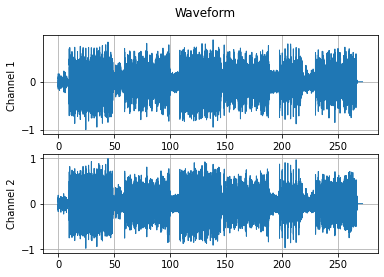

C:\Users\USER\Anaconda3\envs\money\lib\site-packages\matplotlib\axes\_axes.py:7553: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


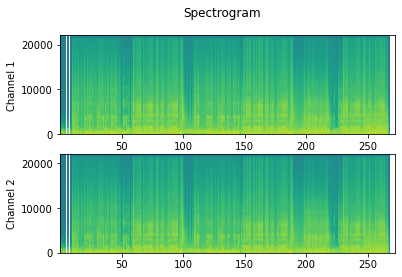

AttributeError: module 'utils' has no attribute 'play_audio'

In [13]:
waveform, sample_rate = torchaudio.load(sample_wav_path)

utils.print_stats(waveform, sample_rate=sample_rate)
utils.plot_waveform(waveform, sample_rate)
utils.plot_specgram(waveform, sample_rate)

In [85]:
# TODO: Create pipeline for audio batching as input
stft = torch.stft(waveform[:,44100:44100*2],n_fft=4096,hop_length=1024,win_length=4096,return_complex=False)
print(stft.shape)
stft = torch.reshape(stft,(2, 2, 2049, 44)).to(device)
stft.shape

# TODO: Create pipeline for audio batching as target


torch.Size([2, 2049, 44, 2])


torch.Size([2, 2, 2049, 44])

In [86]:
class CNN(nn.Module):

    def __init__(self, numChannels, classes, fixedFirstLayer = 48):
        super(CNN, self).__init__() 

        # Encoder 
        self.conv1 = nn.Conv2d(in_channels=numChannels, out_channels=fixedFirstLayer,kernel_size=(8, 8),stride=(4,4))
        self.relu1 = nn.GELU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

        self.conv2 = nn.Conv1d(in_channels=fixedFirstLayer, out_channels=2*fixedFirstLayer,kernel_size=(8, 8),stride=(4,4))
        self.relu2 = nn.GELU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

        self.conv3 = nn.Conv1d(in_channels=2*fixedFirstLayer, out_channels=4*fixedFirstLayer,kernel_size=(8, 8),stride=(4,4))
        self.relu3 = nn.GELU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

        self.conv4 = nn.Conv1d(in_channels=4*fixedFirstLayer, out_channels=8*fixedFirstLayer,kernel_size=(8, 8),stride=(4,4))
        self.relu4 = nn.GELU()
        self.maxpool4 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

        #Bottleneck layer
        self.conv5 = nn.Conv1d(in_channels=8*fixedFirstLayer, out_channels=16*fixedFirstLayer,kernel_size=(8, 8),stride=(8,8))
        self.relu5 = nn.GELU()

        # Decoder 
        self.de_conv1 = nn.ConvTranspose2d(in_channels=16*fixedFirstLayer, out_channels=8*fixedFirstLayer,kernel_size=(8, 8),stride=(4,4))
        self.de_relu1 = nn.GELU()
        self.de_maxpool1 = nn.UpsamplingBilinear2d(kernel_size=(2, 2))

        self.de_conv2 = nn.Conv1d(in_channels=8*fixedFirstLayer, out_channels=4*fixedFirstLayer,kernel_size=(8, 8),stride=(4,4))
        self.de_relu2 = nn.GELU()
        self.de_maxpool2 = nn.MaxUnpool2d(kernel_size=(2, 2))

        self.de_conv3 = nn.Conv1d(in_channels=4*fixedFirstLayer, out_channels=2*fixedFirstLayer,kernel_size=(8, 8),stride=(4,4))
        self.de_relu3 = nn.GELU()
        self.de_maxpool3 = nn.MaxUnpool2d(kernel_size=(2, 2))

        self.de_conv4 = nn.Conv1d(in_channels=2*fixedFirstLayer, out_channels=fixedFirstLayer,kernel_size=(8, 8),stride=(4,4))
        self.de_relu4 = nn.GELU()
        self.de_maxpool4 = nn.MaxUnpool2d(kernel_size=(2, 2))

        self.de_conv4 = nn.Conv1d(in_channels=fixedFirstLayer, out_channels=classes,kernel_size=(8, 8),stride=(4,4))
        self.de_relu4 = nn.GELU()
        self.de_maxpool4 = nn.MaxUnpool2d(kernel_size=(2, 2))

    def forward(self, inputs):
    
        embeddings = self.embeddings(inputs)

        out = self.linear(embeddings)


        return out




In [87]:
class simple_CNN(nn.Module):

    def __init__(self, numChannels, classes, fixedFirstLayer = 48,):
        super(simple_CNN, self).__init__() 

        # Encoder 
        self.conv1 = nn.ConvTranspose2d(in_channels=numChannels, out_channels=classes,kernel_size=(8, 8),stride=(4,4))
        self.gelu1 = nn.GELU()
        # self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

    def forward(self, inputs):
    
        embeddings = self.conv1(inputs)
        out = self.gelu1(embeddings)
        return out

In [88]:
# Create model and pass to CUDA if available.
model = simple_CNN(numChannels = 2, classes = 4)
model = model.to(device)
model.train()

simple_CNN(
  (conv1): ConvTranspose2d(2, 4, kernel_size=(8, 8), stride=(4, 4))
  (gelu1): GELU()
)

In [89]:
# Define training parameters
learning_rate = 0.0001 # Number recommended by wave-u-net paper
epochs = 100
torch.manual_seed(28)
loss_function = nn.MSELoss() # Loss recommended by wave-u-net paper
optimizer = optim.Adam(model.parameters(), lr = learning_rate) # optimiser recommended by wave-u-net paper
 

In [95]:
def train(data, model, epochs, loss_func, optimizer):
    """
    This is a trainer function to train our CNN model.
    """
    # TODO: Use early stopper and tensorboard 

    losses = []
    accuracies = []

    for epoch in range(epochs):
        total_loss = 0
        
        # Forward pass
        model.zero_grad()
        output = model(stft)

        # We repeat the tensor as each vector has the same probabilities
        print(output.shape)

        # FIXME: Create target data
        loss = loss_func(output, target)

        # Backward pass and optim
        total_loss += loss.data.item()
        # print(loss)

        loss.backward()
        optimizer.step()
        
        # Loss update
    
    # Display
    if epoch % 10 == 0:
        # FIXME: Create accuracy checker data
        accuracy = check_accuracy(model, data, word2index, index2word)
        print("Accuracy after epoch {} is {}".format(epoch, accuracy))
        accuracies.append(accuracy)
        losses.append(total_loss)
    return losses, accuracies, model

losses, accuracies, model = train(stft, model, epochs, loss_function, optimizer)

torch.Size([2, 4, 8200, 180])


NameError: name 'target' is not defined